In [ ]:
!git clone https://huggingface.co/spaces/avsarasan/imageclassification

Cloning into 'imageclassification'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (4/4), 1.28 KiB | 435.00 KiB/s, done.


In [ ]:
! pip install --datasets transformers evaluate torch torchvision



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --datasets


In [ ]:
! pip install transformers[torch]

In [ ]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, InterpolationMode, RandomHorizontalFlip, ColorJitter
! pip install evaluate
import evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Load a dataset (e.g., the Beans dataset)
ds = load_dataset('beans')

# Create label mappings
labels = ds['train'].features['labels'].names
label2id = {label: str(i) for i, label in enumerate(labels)}
id2label = {str(i): label for i, label in enumerate(labels)}

# Example: Split the training set into training and validation sets
ds = ds['train'].train_test_split(test_size=0.1)

train_ds = ds['train']
eval_ds = ds['test']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

In [ ]:
# View the metadata for the training dataset
print(train_ds)

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 930
})


In [ ]:
# View the metadata for the training dataset
print(eval_ds)

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 104
})


In [ ]:
# View the metadata for the training dataset
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 930
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 104
    })
})


In [ ]:
# Choose a pre-trained checkpoint (e.g., Google's ViT)
model_checkpoint = "google/vit-base-patch16-224-in21k"

# Load the image processor (tokenizer for vision models)
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

# Load the model with a new classification head
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True # Allow the new classification head size to be different
)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define standard image transformations (as required by the model's processor)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = image_processor.size["height"]

# Training transformations (includes augmentation)
train_transforms = Compose([
    RandomResizedCrop(size),
    ToTensor(),
    normalize,
])

# Evaluation transformations (no augmentation)
eval_transforms = Compose([
    # Resize to model size, convert to tensor, normalize
    RandomResizedCrop(size), # Add RandomResizedCrop for evaluation as well
    ToTensor(),
    normalize,
])

# Preprocessing function to be applied to the dataset
def preprocess_train(example_batch):
    # Apply transformations to a batch of images
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_eval(example_batch):
    example_batch["pixel_values"] = [eval_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

# Apply the transformations "on the fly" when accessing the dataset
train_ds = train_ds.with_transform(preprocess_train)
eval_ds = eval_ds.with_transform(preprocess_eval)

In [ ]:
# Define the data collator for batching (required for Trainer)
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Load the evaluation metric
accuracy_metric = evaluate.load("accuracy")

# Define the compute_metrics function for the Trainer
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)


In [ ]:
# Define Hyperparameters and Training Arguments
training_args = TrainingArguments(
    output_dir="./vit_finetuned_beans",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    remove_unused_columns=False
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=image_processor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

# Start training!
print("Starting Fine-Tuning...")
trainer.train()

# Final Evaluation on the test set
# Optionally, you can use a separate test_ds if you held one back
results = trainer.evaluate(eval_ds)
print(f"Final Evaluation Results: {results}")


/tmp/ipython-input-513331998.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting Fine-Tuning...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.827955,0.826923
2,0.799500,0.481391,0.932692
3,0.799500,0.339466,0.913462


Final Evaluation Results: {'eval_loss': 0.3137441873550415, 'eval_accuracy': 0.9230769230769231, 'eval_runtime': 1.6035, 'eval_samples_per_second': 64.857, 'eval_steps_per_second': 4.365, 'epoch': 3.0}


Loading model and image processor...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Model moved to cuda
Pipeline loaded successfully! Now uploading test image...

--- DEMO START ---
Please upload an external image file (e.g., a picture of a bean leaf):


Saving beans3.jpg to beans3.jpg

--- Running prediction on: beans3.jpg ---
Uploaded Image:


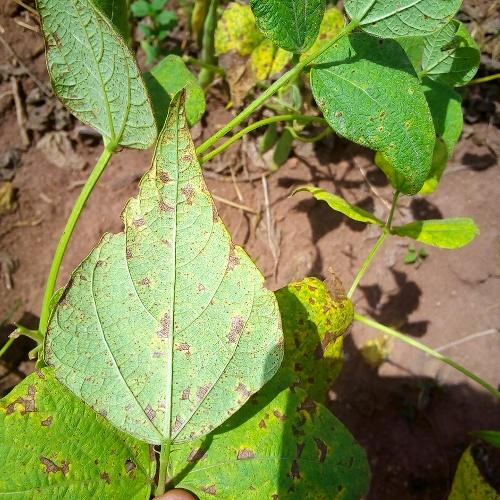



--- CLASSIFICATION RESULT ---
Prediction: **BEAN_RUST**
Confidence: 0.3806

All Results:
- bean_rust           : 0.3806
- angular_leaf_spot   : 0.3347
- healthy             : 0.2846


In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor, pipeline
from google.colab import files
from PIL import Image
import torch
import io
import os

# ⚠️ 1. DEFINE MODEL AND LABELS ⚠️
# Replace this with the name of your fine-tuned model on the Hugging Face Hub
MODEL_CHECKPOINT = "google/vit-base-patch16-224-in21k"
BEANS_LABELS = ['angular_leaf_spot', 'bean_rust', 'healthy']
# The mapping must be from integer IDs (0, 1, 2) to string labels
ID_TO_LABEL = {i: label for i, label in enumerate(BEANS_LABELS)} # NOTE: Keys are integers now, not strings!

# --- 2. LOAD AND CONFIGURE THE MODEL & IMAGE PROCESSOR ---
print("Loading model and image processor...")

# Load the model, explicitly providing the id2label and label2id mappings.
# These dictionaries are inserted directly into the model's config object.
model = ViTForImageClassification.from_pretrained(
    MODEL_CHECKPOINT,
    # Pass the integer-keyed dictionary for id2label
    id2label=ID_TO_LABEL,
    # Pass the label-to-integer dictionary for label2id
    label2id={v: k for k, v in ID_TO_LABEL.items()}
)

# Load the image processor
image_processor = ViTImageProcessor.from_pretrained(MODEL_CHECKPOINT)

# Optional: Move the model to the GPU for faster inference
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
    print(f"Model moved to {device}")

# --- 3. LOAD THE MODEL PIPELINE ---
# Pass the fully configured model and the image_processor object to the pipeline
classifier = pipeline(
    task="image-classification",
    model=model, # Pass the model object
    image_processor=image_processor # Pass the image processor object
)
print("Pipeline loaded successfully! Now uploading test image...")

# --- 4. UPLOAD AND PREDICT (The Demo) ---
# ... (The rest of the upload and prediction code remains the same) ...
print("\n--- DEMO START ---")
print("Please upload an external image file (e.g., a picture of a bean leaf):")
uploaded = files.upload()

if uploaded:
    file_name = next(iter(uploaded))
    input_image = Image.open(io.BytesIO(uploaded[file_name]))

    print(f"\n--- Running prediction on: {file_name} ---")

    print("Uploaded Image:")
    display(input_image)

    results = classifier(input_image)

    print("\n\n--- CLASSIFICATION RESULT ---")
    top_result = results[0]
    # The output from the pipeline will now correctly contain the label string
    print(f"Prediction: **{top_result['label'].upper()}**")
    print(f"Confidence: {top_result['score']:.4f}")

    print("\nAll Results:")
    for result in results:
        print(f"- {result['label']:<20}: {result['score']:.4f}")
else:
    print("No file was uploaded.")